# ModSim Project 2 - Sea Level Rise
by Lilo Heinrich and Chris Allum

## Questions
#### What is the effect of reducing global carbon emission on sea level rise by the year 2050?

This is an explanatory question. It explains the relationship between reducing carbon emissions now and the resulting sea level in 2050. This is an important question to ask because when sea levels rise, many cities will flood, resulting in the displacement of many people. Understanding and being able to predict both how much we need to cut carbon emission now and how much sea levels will rise is vital in planning for the future. By asking the question, we will learn how our current decisions will affect our future way of life.

## Modeling
To answer our proposed question, we created a simulation that models how future sea levels rise in response to the quantity of CO2 in the atmosphere. We will run a sweep series that uses a range of possible future CO2 emisssions that correspond to the varrying amounts we could start reducing our carbon emissions. The results of this sweep series will show how different commitments to reducing carbon emissions will result in varying amounts of sea level rise by the year 2050. We have based our energy stock and flow based on the diagram on page 23 of the 2016 International Union for Conservation of Nature (IUCN) report, linked in our sources[1].

We have made several assumptions in our model. Firstly, we assume that sea level rise is due mainly to two factors: the expansion of water in response to warming oceans and ice sheet melting. We concluded that these two sources were the primary causes of sea level rise, and that trying to model other causes would not make a significant difference to be worth the difficulty it would cause. After looking at how much of the world's water is stored in glaciers (around 2%)[5], we felt that not including them would fall within an acceptable range of error. We also assume that the primary cause of the earth energy imbalance is an increase in carbon dioxide in the atmosphere, and that there is direct causality between cumulative carbon dioxide emissions and increase in energy accumulation.

Within our model, we assume that the two layers of ocean don't mix or interact, for the sake of simplicity. We also assume that the heat absorption ability of the ocean stays the same over time, even though due to CO2 being dissolved into the ocean, its' ability to store heat will decrease very slightly.

In our model, we have the following stocks: carbon dioxide quantity, global ice sheet mass, global ocean mass, global ocean temp, and global ocean volume. We technically only have one flow: mass flow from melted ice into water. We do, however, have many relationships between the stocks such as heat transfer into ocean temp, water temp in to water volume, carbon dioxide into heat transfer.

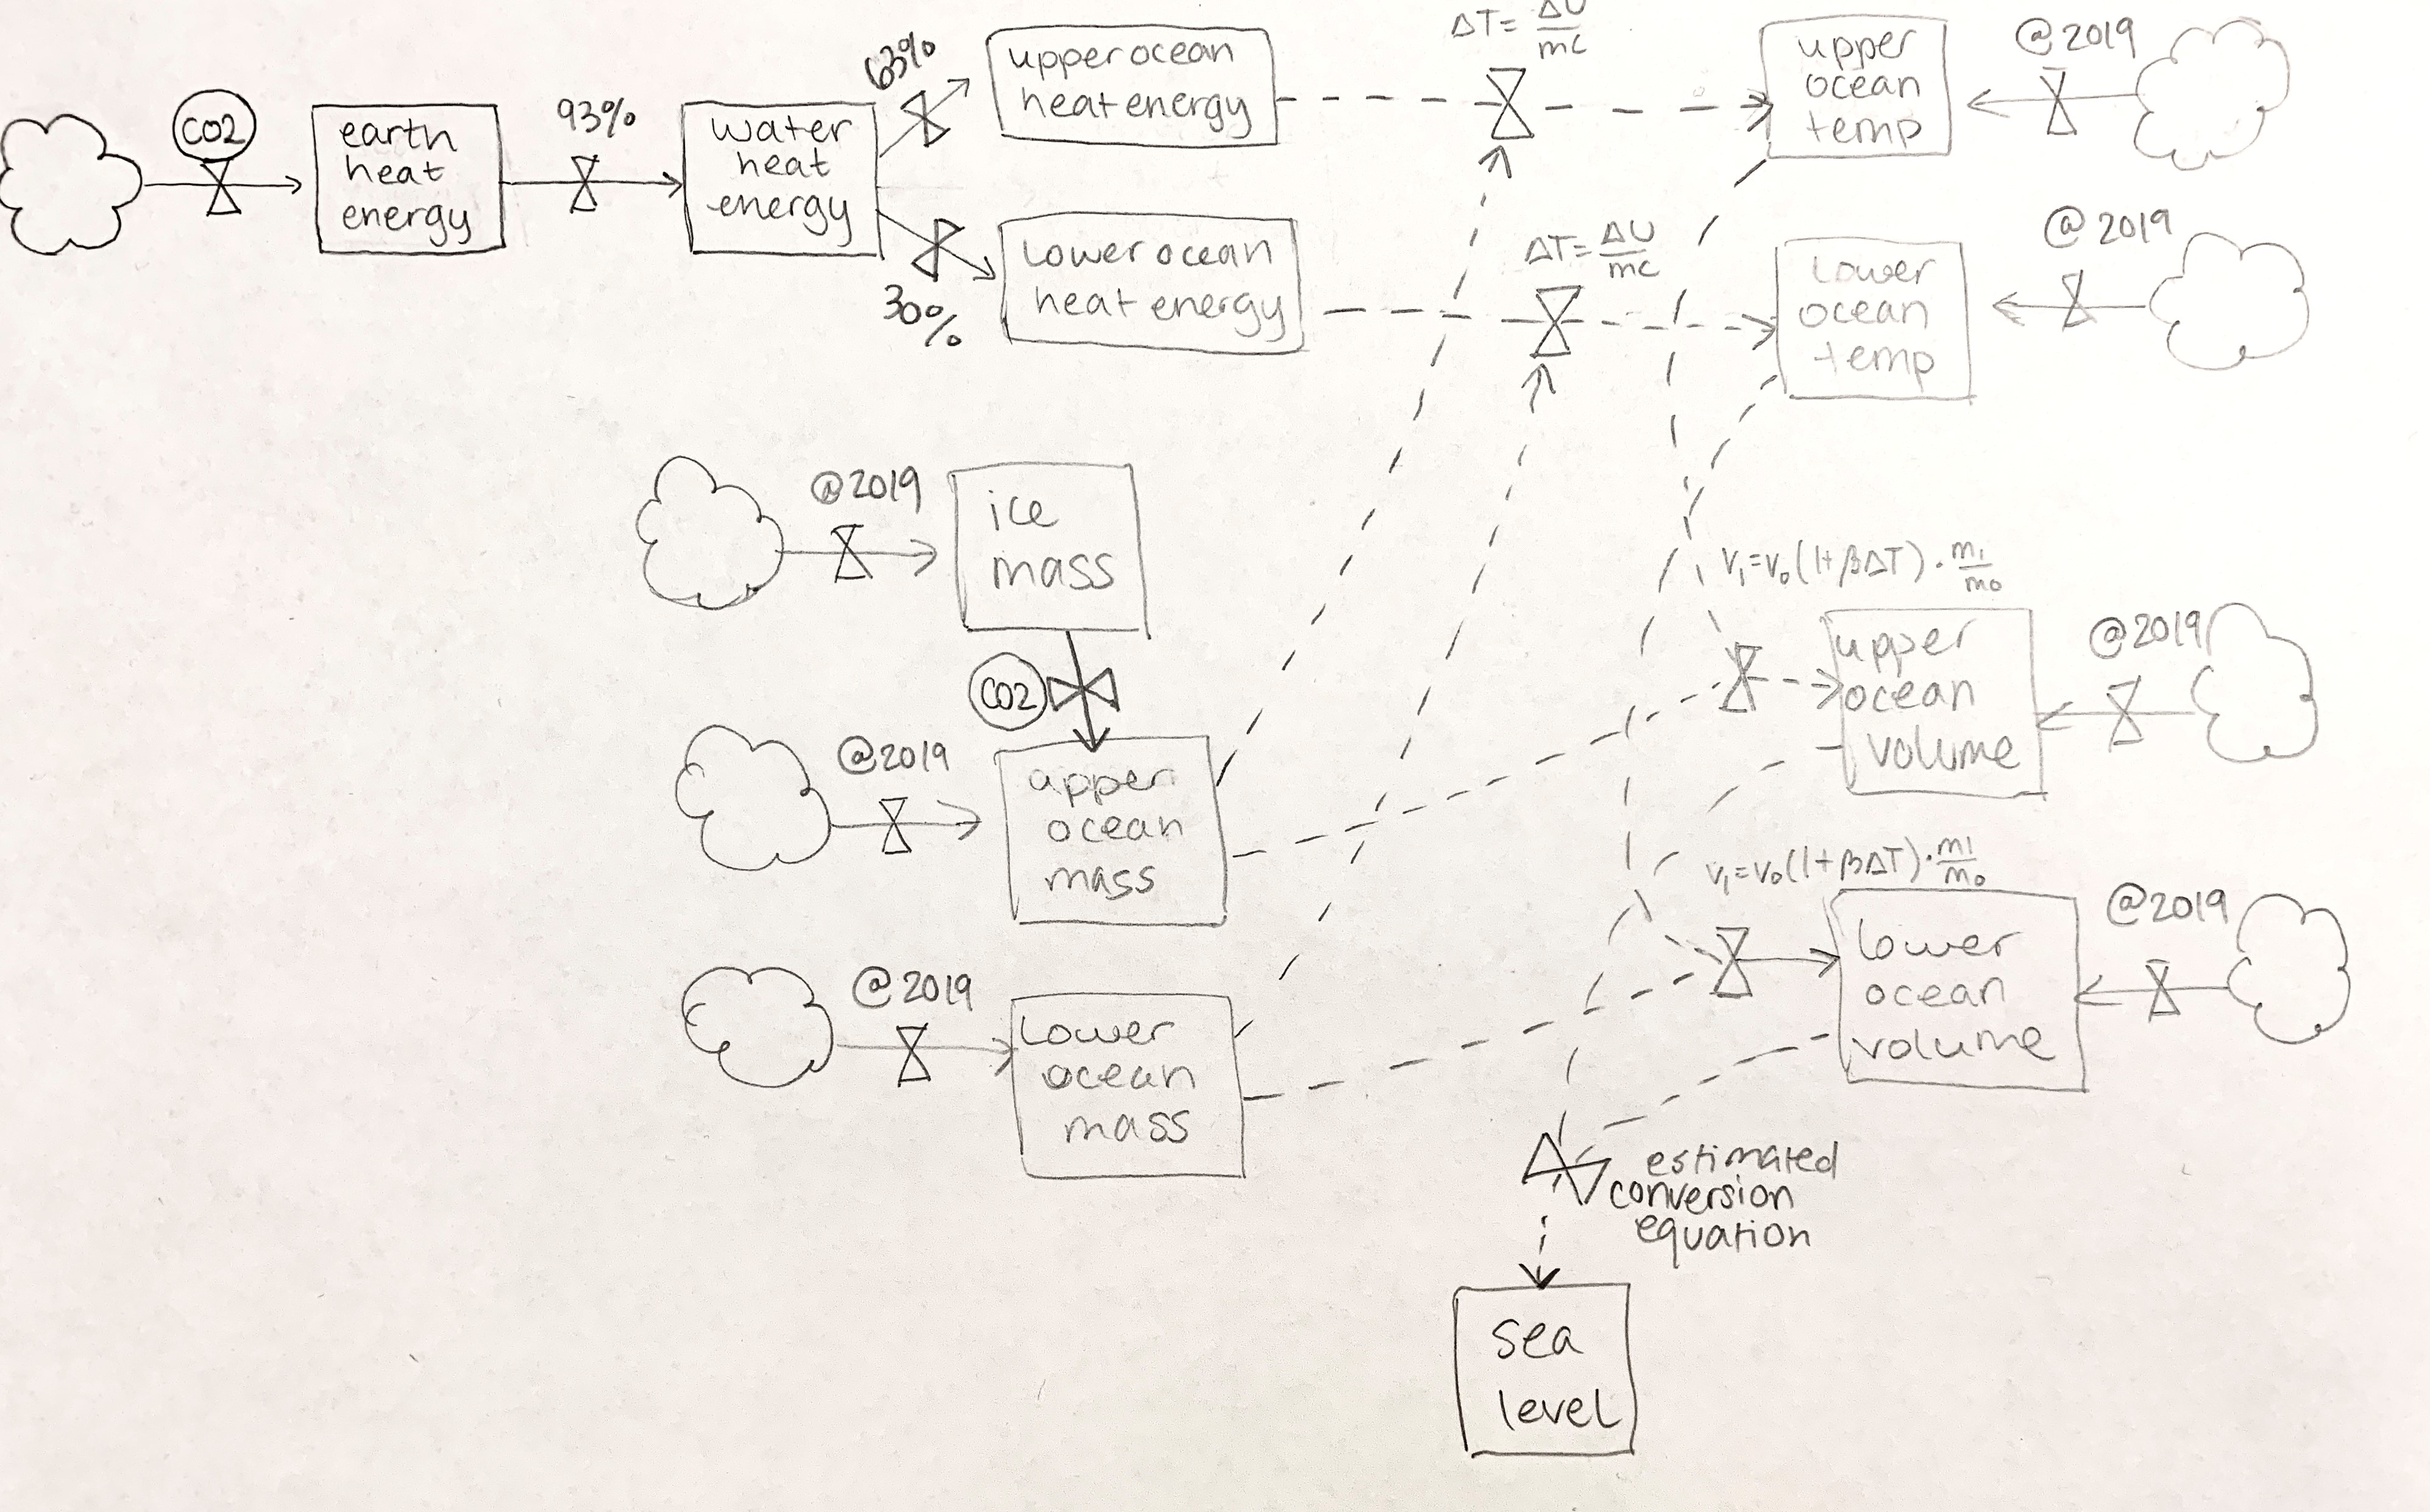

In [3]:
from IPython.display import Image
Image("IMG_1804.jpg", width=750, height=500)

In [7]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# import functions from the modsim.py module
from modsim import *

# for csv reading
import pandas as pd

We set the initial values for our stocks in the make_system function based on the current data, from 2018/2019. Our sources for these initial values are:
- Volumes of Oceans and other bodies of water: [4]
- Masses of ice sheets and other forms of ice: [5]

Other values commonly recognized found on google:
- Sea Water Specific Heat (c) = 3850 J/kg °C
- Water Volumetric Temperature Expansion Coefficient (β) = 0.000207 per degree Celsius [1/°C]

In [8]:
def make_system(alpha, t_0, t_end, dt):

    init = State(ice_mass=2.45e19, upper_mass=1.35e21*0.2, upper_volume=1.35e18*0.2, upper_temp=17, lower_mass=1.35e21*0.8, lower_volume=1.35e18*0.8, lower_temp=4, sea_level=0)
    return System(init=init, c=3850, beta=0.000207, upper_sink=.63, lower_sink=.3, init_volume=1.35e18, alpha=alpha, t_0=t_0, t_end=t_end, dt=dt)

#### Equations
The main four types of stocks that we have are Energy, Temperature, Mass, and Volume. We calculate these flow or conversion between these quantities in the following ways:
- Energy & Mass (ice sheet melting) as best fit equations based on cumulative CO2 (CO2 data: [2], Ice melting data: [3], Heat energy data: [7])
  - Energy added to Earth is calculated as: $U'(t) = f(CO2(t))$
    - Energy added to Earth's water is about 93%, 63% in upper layer, 30% in lower [1]
    - Upper Ocean Energy: $U_u'(t)=U'(t)*0.63$
    - Lower Ocean Energy: $U_l'(t)=U'(t)*0.30$
  - Ice mass melted per year is calculated in the same way $M'(t) = f(CO2(t))$
    - Ice Mass: $M_i'(t)=-M'(t)$
    - Upper Ocean Mass: $M_u'(t)=M'(t)$
    - Lower Ocean Mass doesn't change because we assume that the icewater mainly mixes into what we defined as "upper layer": $M_l'(t)=0$
- Temperature
  - Temperature change from heat added to oceans is calculated from mass and energy [10]:
    - Temperature in lower layer: $T_l'(t)=U_l'(t)/Ml(t)/c$
  - Temperature change from mixing in icewater (temp 0 °C) is accounted for in the upper layer using a rearrangement of Newton's Law of Cooling [9]:
    - Temperature in upper layer: $T_u'(t)=U_u'(t)/M_u(t)/c+T_u(t-1)*(M_u(t-1)/M_u(t)-1)$
- Volume
  - Volumetric expansion uses mass and temperature [8]:
    - Volume of upper layer: $V_u'(t)=\beta*T_u'(t)*M_u(t)/M_u(t-1)$
    - Volume of lower layer: $V_l'(t)=\beta*T_l'(t)$
- Sea Level
  - Estimated equation [6]: $S'(t)=(V_u+V_l)/361.8e9$

In [13]:
def CO2_func(year):
    return (8.35e17) - (8.61e14 * year) + (2.22e11 * year**2)

In [1]:
def update_func(state, t, system):

    ice_mass, upper_mass, upper_volume, upper_temp, lower_mass, lower_volume, lower_temp, sea_level = state
    alpha = system.alpha

    delta_energy = (7.13e7*((CO2_func(t)-CO2_func(system.t_0))*(1-alpha)+CO2_func(system.t_0)) - 3.28e22)
    delta_ice_loss = (0.182*((CO2_func(t)-CO2_func(system.t_0))*(1-alpha)+CO2_func(system.t_0))- 1.16e14)

    upper_energy = delta_energy * system.upper_sink
    lower_energy = delta_energy * system.lower_sink

    # ice mass into water
    ice_mass -= delta_ice_loss
    upper_mass += delta_ice_loss

    # water temp update
    upper_delta_temp = ((upper_mass-delta_ice_loss)/upper_mass - 1) * upper_temp # mix in melted icewater
    upper_delta_temp += upper_energy / (upper_mass*system.c) # calculate temp from added heat
    upper_temp += upper_delta_temp

    lower_delta_temp = lower_energy / (lower_mass*system.c)
    lower_temp += lower_delta_temp

    # save previous total water volume
    prev_total_volume = upper_volume + lower_volume

    # water vol update due to expansion
    upper_volume *= (1+system.beta*upper_delta_temp)*(upper_mass/(upper_mass-delta_ice_loss))
    lower_volume *= (1+system.beta*lower_delta_temp)

    # calculate sea level rise (mm)
    delta_volume = upper_volume + lower_volume - prev_total_volume
    sea_level += (delta_volume/1e9)/361.8

    return State(ice_mass = ice_mass, upper_mass=upper_mass, upper_volume=upper_volume, upper_temp=upper_temp, lower_mass=lower_mass, lower_volume=lower_volume, lower_temp=lower_temp, sea_level=sea_level)

In [2]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    Adds a TimeFrame to the System: results

    system: System object
    update_func: function that updates state
    """
    init, t_0, t_end, dt = system.init, system.t_0, system.t_end, system.dt
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)

    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)

    return frame

In [3]:
def plotData(plot, xlabel, ylabel, color, xdata, ydata, legend, doubleAxis):
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel, color=color[0])
    plot1, = plot.plot(xdata, ydata[0], color=color[0])
    plot.tick_params(axis='y', labelcolor=color[0])

    if doubleAxis:
        axis = plot.twinx()
        axis.set_ylabel(ylabel, color=color[1])
        plot2, = axis.plot(xdata, ydata[1], color=color[1])
        axis.tick_params(axis='y', labelcolor=color[1])
        plot.legend((plot1, plot2),(legend[0], legend[1]), fontsize=10, loc='upper right')
    else:
        plot.legend([legend], fontsize=10, loc='upper right')

In [4]:
def plot_results(results):
    fig, ((pl1, pl2), (pl3, pl4)) = plt.subplots(2, 2, figsize=(12, 8))
    time = [i*system.dt + system.t_0 for i in range(system.t_end - system.t_0+1)]

    massData = [results.upper_mass+results.lower_mass,results.ice_mass]
    volData = [results.upper_volume, results.lower_volume]
    tempData = [results.upper_temp,results.lower_temp]
    levelData = [results.sea_level]

    plotData(pl1,'Year','Mass (kg)',['tab:red','tab:cyan'],time,massData,['total_mass','ice_mass'],True)
    plotData(pl2,'Year','Volume (m^3)',['tab:orange','tab:blue'],time,volData, ['upper_vol', 'lower_vol'], True)
    plotData(pl3,'Year','Temp (C)',['tab:olive','tab:purple'],time,tempData,['upper_temp','lower_temp'],True)
    plotData(pl4,'Year','Height (mm)', ['tab:green'], time, levelData, 'sea_level', False)

    fig.tight_layout()

In [5]:
def sweepAlpha(t_0, t_end, dt, alphaSeries):

    sea_level_rise = [i for i in range(numPoints)]

    for i in range(len(alphaSeries)):
        system = make_system(alphaSeries[i], t_0, t_end, dt)
        results = run_simulation(system, update_func)
        sea_level_rise[i] = results.sea_level[t_end]

    return sea_level_rise

# Results

#### Results: 0% Reduction in Carbon Dioxide Emissions

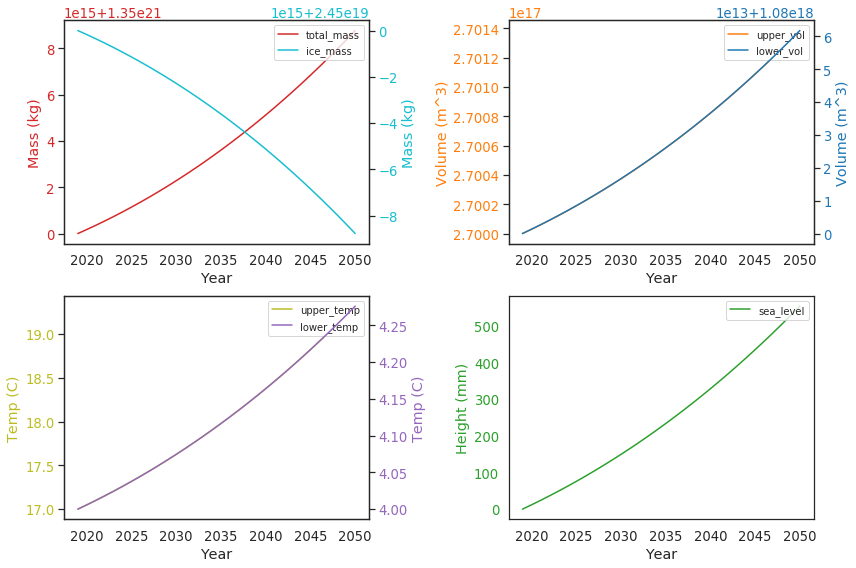

In [10]:
# run the simulation with 0% reduction and plot results
alpha = 0 # percent co2 emissions reduction from predicted value
t_0 = 2019
t_end = 2050
dt = 1

system = make_system(alpha, t_0, t_end, dt)
results = run_simulation(system, update_func)
plot_results(results)

#### Results: 100% Reduction in Carbon Dioxide Emissions

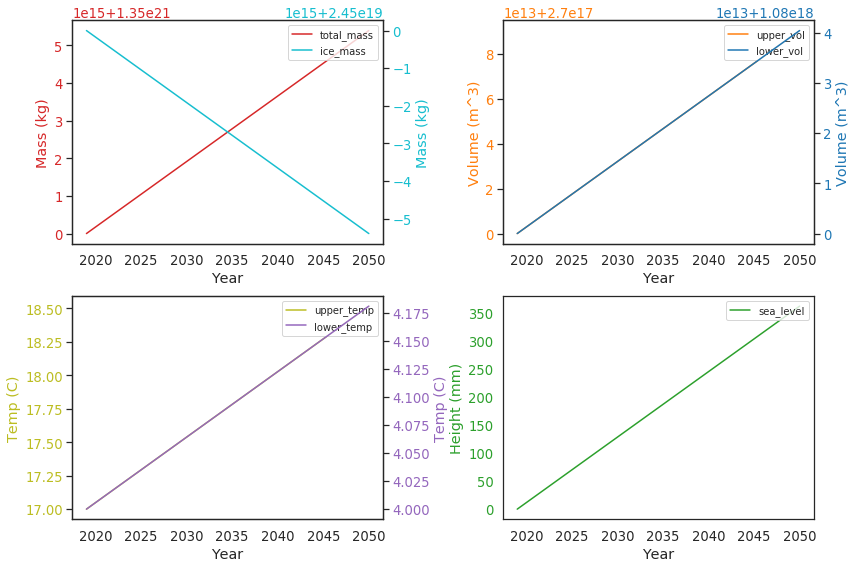

In [11]:
# run the simulation with 100% reduction and plot results
alpha = 1.0 # percent co2 emissions reduction from predicted value
t_0 = 2019
t_end = 2050
dt = 1

system = make_system(alpha, t_0, t_end, dt)
results = run_simulation(system, update_func)
plot_results(results)

Text(0, 0.5, 'Sea level rise in mm')

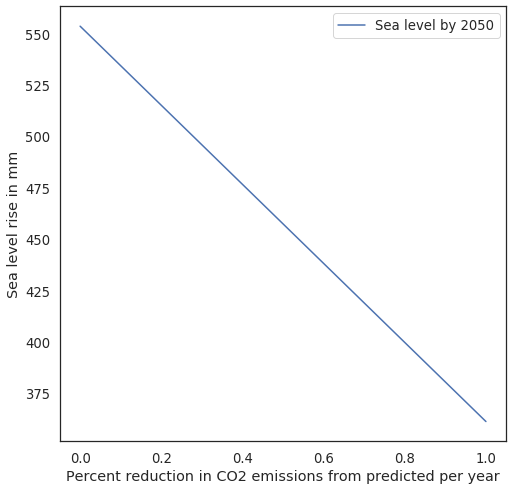

In [12]:
numPoints = 100
t_0 = 2019
t_end = 2050
dt = 1

alphaSeries = linspace(0,1,numPoints)
sea_level_rise = sweepAlpha(t_0, t_end, dt, alphaSeries)

fig, pl = plt.subplots(1, 1, figsize=(8, 8))
pl.plot(alphaSeries, sea_level_rise)
pl.legend(['Sea level by 2050'])
pl.set_xlabel('Percent reduction in CO2 emissions from predicted per year')
pl.set_ylabel('Sea level rise in mm')

#### Results Summary
With 0% reduction in carbon dioxide emissions, we get the following results:
- 2 degree increase in sea temperature at the top 700m
- 550mm rise in sea levels

With 100% reduction in carbon dioxide emissions, we get the following results:
- 1.5 degree increase in sea temperatures at the top 700m
- 360mm rise in sea levels

##### Validation
As percent reduction in CO2 emissions increases, sea level predictions linearly decrease, but remain non-zero. This result makes sense, because CO2 generally cannot leave our atmosphere once it has been emitted, showing that our model has face validity.

In order to externally validate our result for sea level rise, we compared its' output to a model used in a scientific publication, page 87 of "Sea-Level Rise for the Coasts of California, Oregon, and Washington" from the National Resource Council [11]. It predicted an approximate minimum sea level rise of 30cm and a maximum of 50cm by 2050. This gives our model an approximate 10% error with respect to these prediction models, since our model's high is 55cm and low is 36cm.

## Interpretation

#### Question: What is the effect of reducing global carbon emission on sea level rise by the year 2050?
The effect of reducing global carbon emission by 100% on sea level rise by the year 2050 is a difference of 190mm, or 0.19m. Reducing or even eliminating future CO2 emissions will not reverse the damage to our climate system. Since we cannot take back past actions, sea level will continue to rise in the future no matter our emission rate. However, reducing our emissions can slow the rate of sea level rise up to 35%, which is a significant impact.

#### Timescale:
We are running our model on a time scale of decades (running from 2019 to 2050). This is an appropriate timescale to run the simulation over since the process of global climate change is very slow. If we were to run a simulation for anything less than a few years, any changes in the stocks would be so small that they would fall within the range of error. Our model only produces clear trends when run over a long time period. For the time scale that we are running the simulation, the results seem very accurate. All of our results are reasonable, especially given that other predictions based on past sea level give results with similar outcomes.

#### Missing Aspects
Our model lacks a lot of the complexity of the real world. For example, it doesn't take into account the effects of other greenhouse gases, it doesn't take into account the changing absorption rate of CO2 in the ocean, or the fact that ice sheet aren't the only source of added water to the ocean. In total, however, these other elements would not change our model by a significant margin. Our model covers the two primary means of ocean sea level rise. If we were to include these elements, our results would probably change by less than 10%.

#### Model Complexity
The problem with modelling complex environmental systems is that they have many important aspects to take into consideration. It is not possible to separate out one aspect, such as sea level, and model it independently from other relevant quantities such as ocean temperature, ocean CO2 absorption, and ice sheet and glacier melting. And for example, ocean acidification requires both an understanding of chemichal reactions and thermodynamics in order to model. The interdependence and interdisciplinary nature of our planet's climate system makes modelling it a very difficult task.

[1] Explaining Ocean Warming Report by the International Union for Conservation of Nature (IUCN), Chapter 1 (p. 17-45): https://portals.iucn.org/library/sites/library/files/documents/2016-046_0.pdf

[2] Greenhouse Gas emissions quantified, Data by year (can download as csv):  https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions

[3] Ice Sheet Melting in Antarctic and Greenland, Data by year (can download as excel sheet): https://www.eea.europa.eu/data-and-maps/daviz/cumulative-ice-mass-loss-and#tab-dashboard-01

[4] Volumes of Oceans and Bodies of Water reference: https://www.ngdc.noaa.gov/mgg/global/etopo1_ocean_volumes.html

[5] Masses of Ice Sheets: http://www.antarcticglaciers.org/glaciers-and-climate/what-is-the-global-volume-of-land-ice-and-how-is-it-changing/

[6] Volume to Sea Level Conversion Equation: http://www.antarcticglaciers.org/glaciers-and-climate/estimating-glacier-contribution-to-sea-level-rise/

[7] Ocean Heat Content, Data by year (as csv): https://www.e-education.psu.edu/earth107/node/1502

[8] Volumetric Expansion Equation: https://www.engineeringtoolbox.com/volumetric-temperature-expansion-d_315.html

[9] ModSim textbook excerpt about Heat, Newton's Equation of Coooling (p. 134-138): http://greenteapress.com/modsimpy/ModSimPy3.pdf

[10] Specific Heat/Heat Energy to Temperature Conversion Equation: http://hyperphysics.phy-astr.gsu.edu/hbase/thermo/spht.html

[11] Future predicted Sea Level from National Research Council: https://www.nap.edu/read/13389/chapter/7#87